<a href="https://colab.research.google.com/github/diem-ai/datascience-projects/blob/master/sentiment_mining/sentiment_prediction2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**:

- The goal of this first notebook is to explore logistic regression and feature engineering with existing sklearn functions.

- In this notebook I will use product review data from Amazon.com to predict whether the sentiments about a product (from its reviews) are positive or negative or neutral.

- Train a logistic regression model to predict the sentiment of product reviews.
- Inspect the weights (coefficients) of a trained logistic regression model.
- Make a prediction (both class and probability) of sentiment for a new product review.
- Evaluation model's performance with accuracy score and classification report

In [0]:
from google.colab import drive
drive.mount('/content/drive')
import sys
# To add a directory with your code into a list of directories 
# which will be searched for packages
sys.path.append('/content/drive/My Drive/Colab Notebooks')

!pip install PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import pandas as pd

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')



my_module = drive.CreateFile({'id':'1Enp9yAAEX3vD1XmWqVzfmjW_xTcu8XlU'})
my_module.GetContentFile('text_accessory.py')

from text_accessory import say_hello
from text_accessory import say_somethingelse


## Data preparation

<p>We will use a dataset consisting of baby product reviews on Amazon.com</p>
<p>This step includes exploring and cleaning data</p>

**Loading dataset**

In [0]:
filepath = '/content/drive/My Drive/data/' 
products = pd.read_csv(filepath + 'amazon_baby.csv')

products = products[['name','review', 'rating']]

**Data Structure**

In [0]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183531 entries, 0 to 183530
Data columns (total 3 columns):
name      183213 non-null object
review    182702 non-null object
rating    183531 non-null int64
dtypes: int64(1), object(2)
memory usage: 4.2+ MB


In [0]:
products.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


**Data Cleaning**

- Remove punctuation Python's built-in string functionality.
- Remove alpha numerical words
- Lower and remove stop words
- Lemmatizer: It reduces the inflected words properly ensuring that the root word belongs to the language. We need to provide the context in which you want to lemmatize that is the parts-of-speech (POS). This is done by giving the value for pos parameter in wordnet_lemmatizer.lemmatize

In [0]:
# using processing_text in text_accessory.py to clean the reviews
from text_accessory import processing_text

#products = products.fillna({'review':''})  # fill in N/A's in the review column
products = products.dropna()
products['clean_review'] = products['review'].apply(processing_text)


In [0]:
products.head()

,name,review,rating,clean_review
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,these flannel wipes ok opinion worth keeping ...
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,came early disappointed love planet wise bags...
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,very soft comfortable warmer looks fit full s...
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,this product well worth purchase i found anyt...
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,all kids cried nonstop i tried ween pacifier ...


In [0]:
products['review_len'] = products['clean_review'].apply(lambda x : len(x))

In [0]:
products['word_count'] = products['clean_review'].apply(lambda x : len(x.split()))

In [0]:
products.head()

,name,review,rating,clean_review,review_len,word_count
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,these flannel wipes ok opinion worth keeping ...,301,43
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,came early disappointed love planet wise bags...,108,16
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,very soft comfortable warmer looks fit full s...,100,15
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,this product well worth purchase i found anyt...,248,38
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,all kids cried nonstop i tried ween pacifier ...,261,44


**Data Distribution**

-  How are ratings distributed over dataset ?
-  How is the length of review distributed ?

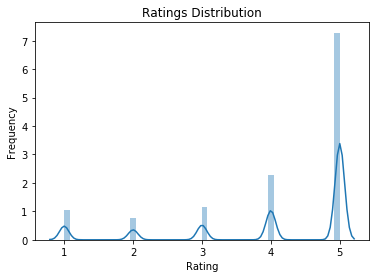

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(products['rating'])
plt.title("Ratings Distribution")
plt.ylabel("Frequency")
plt.xlabel("Rating")
plt.show()

**Observation**

From histogram chart, it is observed that most of the ratings are pretty high at 4 or 5 ranges.

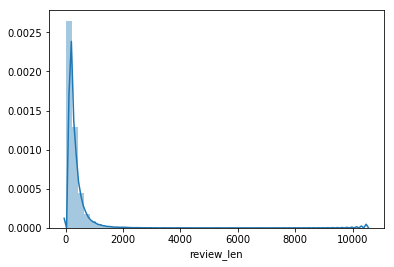

In [0]:
sns.distplot(products['review_len'])

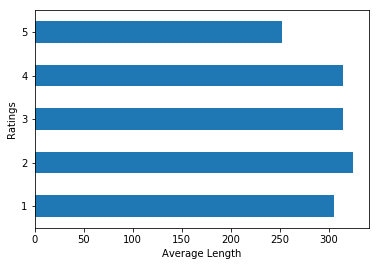

In [0]:
products.groupby(['rating'])['review_len'].mean().plot(kind='barh')
plt.ylabel('Ratings')
plt.xlabel('Average Length')
plt.show()

**Observation**

- The length of reviews are not fairly distributed and it is quite short. 
- The average length of rating 5 reviews are shorter than others ratings & the difference is not huge.

**Word counts distribution**


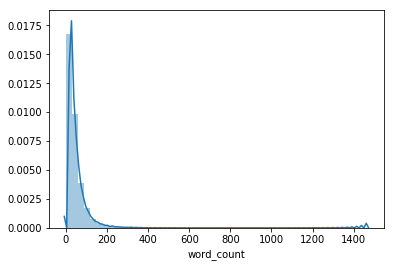

In [0]:
sns.distplot(products['word_count'])
plt.show()

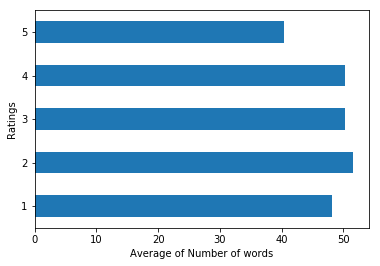

In [0]:
products.groupby(['rating'])['word_count'].mean().plot(kind='barh')
plt.ylabel('Ratings')
plt.xlabel('Average of Number of words')
plt.show()


**Observation**

- There were quite number of people like to leave long reviews
- The higher rating is, the fewer words the reviews are

Create a new column: sentiment

- rating between 4 and 5, sentiment = 1
- rating between 1 and 2, sentiment = -1
- rating 3, sentiment = 0







In [0]:
products['sentiment'] = products['rating'].apply(lambda x : 1 if (x >= 4)  else(0 if x==3 else -1))

In [0]:
products.head()

,name,review,rating,clean_review,review_len,word_count,sentiment
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,these flannel wipes ok opinion worth keeping ...,301,43,0
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,came early disappointed love planet wise bags...,108,16,1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,very soft comfortable warmer looks fit full s...,100,15,1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,this product well worth purchase i found anyt...,248,38,1
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,all kids cried nonstop i tried ween pacifier ...,261,44,1


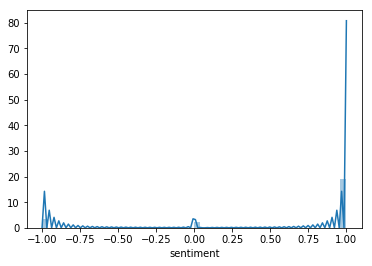

In [0]:
sns.distplot(products['sentiment'])
plt.show()

**Visualiza words in negative reviews in wordscloud**

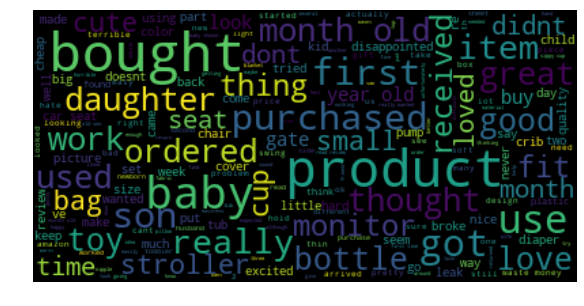

In [0]:
negative_review = products[products['sentiment'] == -1]['clean_review'].to_string()

from text_accessory import get_wordcloud

get_wordcloud(negative_review)

In [0]:
from nltk.corpus import stopwords, wordnet

def get_wordnet_pos(treebank_tag):
    """Convert the part-of-speech naming scheme
       from the nltk default to that which is
       recognized by the WordNet lemmatizer"""

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
      

def get_adjective(text):
  """  
  text: is an array of string
  
  return an array of adjective words
  """
  adj = []
  # Iterare the corpus
  for sent in text:
    # tag part-of-speech to each word in the sentence
    try:
      pos_tag_sent = nltk.pos_tag(sent.split())
      # Select the adject word only
      for (word, tag) in pos_tag_sent:
        if (tag == "JJ"):
          adj.append(word)
    except:
      print("error: {}".format(sent))

  return adj

def get_verbs(text):
  """  
  text: is an array of string
  
  return an array of verbs
  """
  verbs = []
  # Iterare the corpus
  for sent in text:
    # tag part-of-speech to each word in the sentence
    try:
      pos_tag_sent = nltk.pos_tag(sent.split())
      # Select the adject word only
      for (word, tag) in pos_tag_sent:
        if (tag in ["VBG", "VBD"]):
          verbs.append(word)
    except:
      print("error: {}".format(sent))

  return verbs

def get_nouns(text):
  """  
  text: is an array of string
  
  return an array of noun
  """
  nouns = []
  # Iterare the corpus
  for sent in text:
    # tag part-of-speech to each word in the sentence
    try:
      pos_tag_sent = nltk.pos_tag(sent.split())
      # Select the adject word only
      for (word, tag) in pos_tag_sent:
        if (tag == "NN"):
          nouns.append(word)
    except:
      print("error: {}".format(sent))

  return nouns

In [0]:
adj_postive_review = get_adjective(products[products['sentiment'] == 1]['clean_review'].values)

adj_postive_review



'\n\nadj_postive_review = get_adjective()\n\nadj_postive_review\n\n'

**Visualize adjective words in negative reviews in wordscloud**

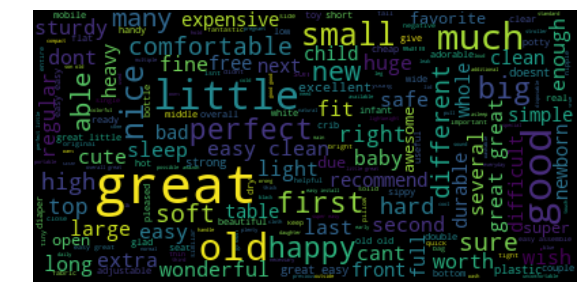

In [0]:
get_wordcloud(' '.join(adj_postive_review))

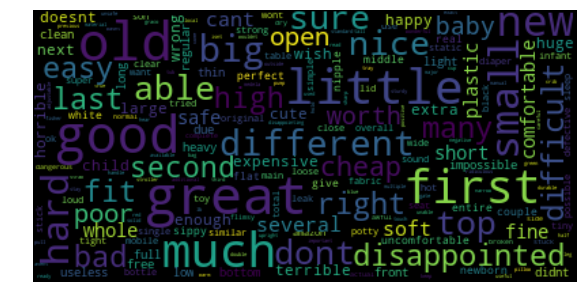

In [0]:
adj_neg_review = get_adjective(products[products['sentiment'] == -1]['clean_review'].values)

get_wordcloud(' '.join(adj_neg_review))


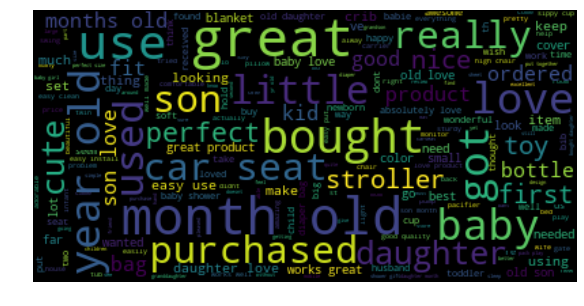

In [0]:
positive_review = products[products['sentiment'] == 1]['clean_review'].to_string()
get_wordcloud(positive_review)

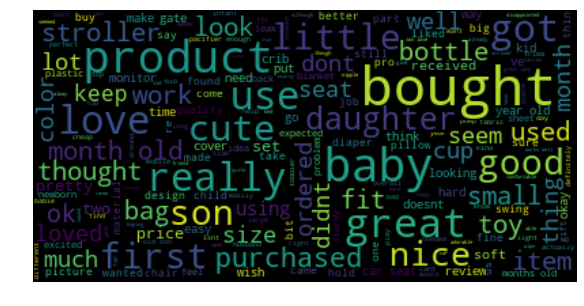

In [0]:
neutral_reviews = products[products['sentiment'] == 0]['clean_review'].to_string()
get_wordcloud(neutral_reviews)

In [0]:
adj_neu_review = get_adjective(products[products['rating']==3]['clean_review'].values)

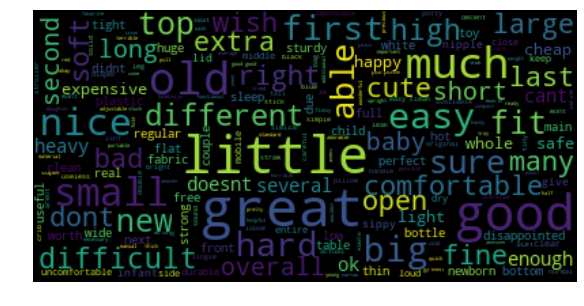

In [0]:
get_wordcloud(' '.join(adj_neu_review))

Word cloud for vebs

In [0]:
verb_pos_rev = get_verbs(products[products['sentiment'] == 1]['clean_review'].values)

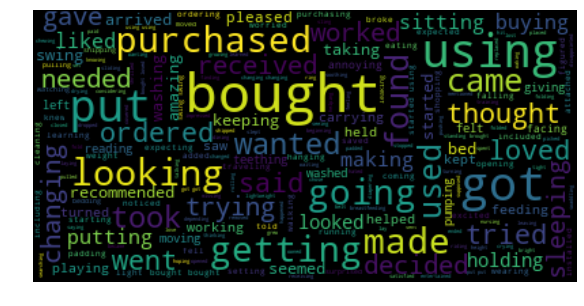

In [0]:
get_wordcloud(' '.join(verb_pos_rev))

In [0]:
verb_neg_rev = get_verbs(products[products['sentiment'] == -1]['clean_review'].values)

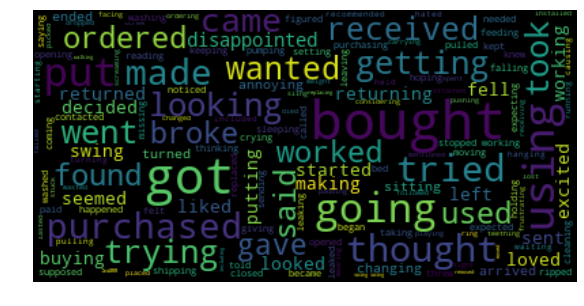

In [0]:
get_wordcloud(' '.join(verb_neg_rev))

Word cloud for Nouns

In [0]:
nous_pos_rev = get_nouns(products[products['sentiment'] == 1]['clean_review'].values)

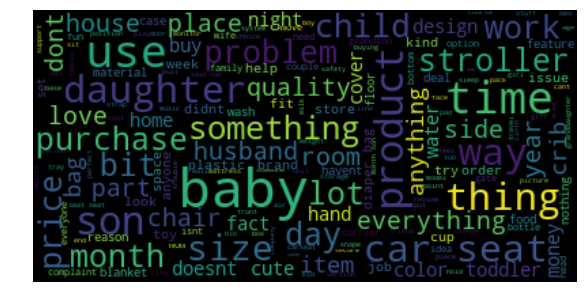

In [0]:
get_wordcloud(' '.join(nous_pos_rev))

In [0]:
!pip install multidict

import multidict as multidict

import numpy as np

import os
import re
from PIL import Image
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def getFrequencyDictForText(sentence):
  '''
  sentence: a list of word
  return a dicttionary whose key is a word and value their frequency
  '''
  fullTermsDict = multidict.MultiDict()
  tmpDict = {}

  # making dict for counting frequencies
  try:
    for word in sentence.split(" "):
      if re.match("ba|sds|jja|dfd|snp|the|to|in|for|of|or|by|with|is|on|that|be|these|eo|blt|dex|wb|ah|gen", word):
        continue
        # Initalize with frequency 0
      val = tmpDict.get(word, 0)
      tmpDict[word.lower()] = val + 1
  except:
      print()
      
  for key in tmpDict:
      fullTermsDict.add(key, tmpDict[key])
  return fullTermsDict

def makeImage(text):
    #alice_mask = np.array(Image.open("alice_mask.png"))

    wc = WordCloud(collocations=False, background_color="white", max_words=100, max_font_size=20)
    # generate word cloud
    wc.generate_from_frequencies(text)

    # show
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    
'''
wordcloud = WordCloud(max_font_size=40).generate(reviews)
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
'''
#makeImage(getFrequencyDictForText(text))

     |████████████████████████████████| 317kB 6.6MB/s 


'\nwordcloud = WordCloud(max_font_size=40).generate(reviews)\n    plt.figure(figsize=(20, 10))\n    plt.imshow(wordcloud, interpolation="bilinear")\n    plt.axis("off")\n'

In [0]:
clean_reviews = products['clean_review'].values

fullTermsDict = multidict.MultiDict()

for rev in clean_reviews:
  fullTermsDict.update(getFrequencyDictForText(rev))

sortedTermList = sorted(fullTermsDict.items(), key=lambda fullTermsDict: fullTermsDict[1], reverse=True)
mydict = {}
for (key, value) in sortedTermList:
  mydict.update({key: value})

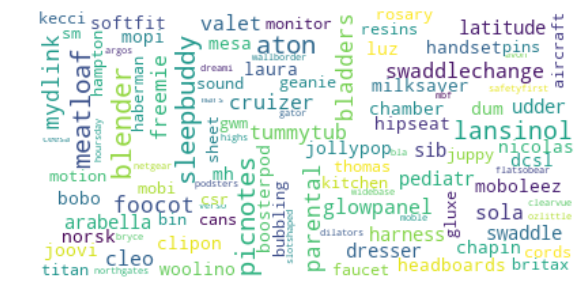

In [0]:
makeImage(mydict)

In [0]:
verb_pos_rev = get_verbs(products[products['sentiment'] == 1]['clean_review'].values)
verbTermsDict = multidict.MultiDict()

for rev in verb_pos_rev:
  verbTermsDict.update(getFrequencyDictForText(rev))

sortedVerbist = sorted(verbTermsDict.items(), key=lambda verbTermsDict: verbTermsDict[1], reverse=True)
mydict = {}
for (key, value) in sortedVerbist:
  mydict.update({key: value})
  


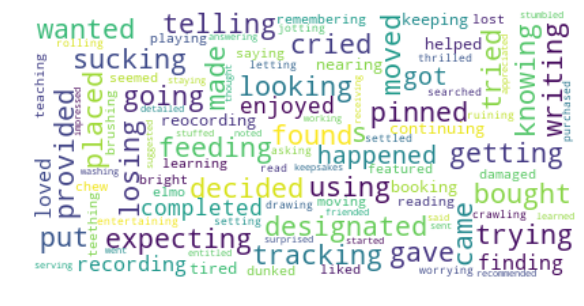

In [0]:
makeImage(mydict) 

In [0]:
verb_neg_rev = get_verbs(products[products['sentiment'] == -1]['clean_review'].values)
verbTermsDict = multidict.MultiDict()

for rev in verb_neg_rev:
  verbTermsDict.update(getFrequencyDictForText(rev))

sortedVerbist = sorted(verbTermsDict.items(), key=lambda verbTermsDict: verbTermsDict[1], reverse=True)
mydict = {}
for (key, value) in sortedVerbist:
  mydict.update({key: value})

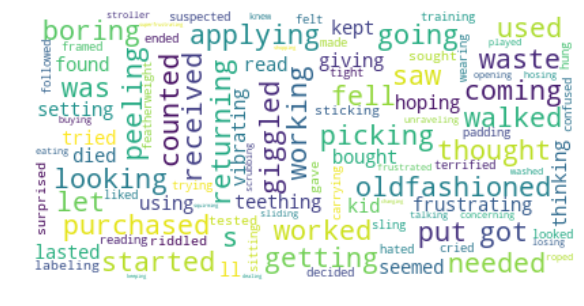

In [0]:
makeImage(mydict)

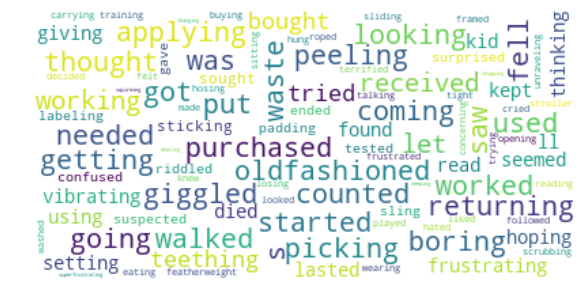

In [0]:
verb_neg_rev = get_verbs(products[products['sentiment'] == -1]['clean_review'].values)
verbTermsDict = multidict.MultiDict()

for rev in verb_neg_rev:
  verbTermsDict.update(getFrequencyDictForText(rev))

sortedVerbist = sorted(verbTermsDict.items(), key=lambda verbTermsDict: verbTermsDict[1], reverse=True)
mydict = {}
for (key, value) in sortedVerbist:
  mydict.update({key: value})
  
makeImage(mydict) 

In [0]:
adj_pos_rev = get_adjective(products[products['sentiment'] == 1]['clean_review'].values)


In [0]:
adjTermsDict = multidict.MultiDict()

for rev in adj_pos_rev:
  adjTermsDict.update(getFrequencyDictForText(rev))

sortedAdjDist = sorted(adjTermsDict.items(), key=lambda adjTermsDict: adjTermsDict[1], reverse=True)
mydict = {}
for (key, value) in sortedAdjDist:
  mydict.update({key: value})



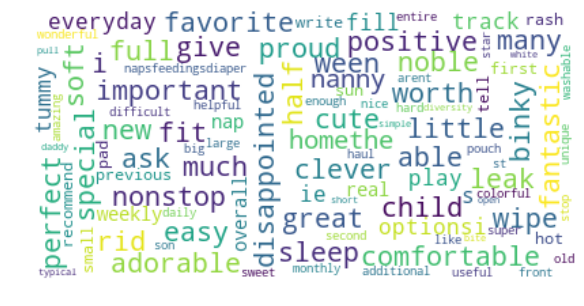

In [0]:
makeImage(mydict)

In [0]:
adj_neg_rev = get_adjective(products[products['sentiment'] == -1]['clean_review'].values)

adjTermsDict = multidict.MultiDict()

for rev in adj_neg_rev:
  adjTermsDict.update(getFrequencyDictForText(rev))

sortedAdjDist = sorted(adjTermsDict.items(), key=lambda adjTermsDict: adjTermsDict[1], reverse=True)
mydict = {}
for (key, value) in sortedAdjDist:
  mydict.update({key: value})



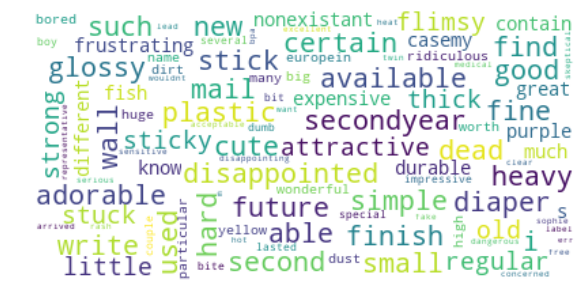

In [0]:
makeImage(mydict)

In [0]:
criteria = products['clean_review'].str.contains('disappointed', na=False)


products[criteria].iloc[0]['review']


'it came early and was not disappointed. i love planet wise bags and now my wipe holder. it keps my osocozy wipes moist and does not leak. highly recommend it.'

In [0]:
products.iloc[27]['review']

"My son loves peek a boo at this age of 9 months so I thought this book would be perfect! This book doesn\\'t engage him enough though it seems.  He does however like the cover the most if I make pretend blow-kisses and peekaboo gestures with the hands and show him. He also likes when I fan the hair towards his face.Maybe when he\\'s older he will flip the flaps but right now he just likes the mirror at the end and the front cover. If I flip the book through he just takes the book and shakes it around."

In [0]:
products.iloc[27]['clean_review']

'my son loves peek boo age  months i thought book perfect  this book doesnt engage enough though seems  he however like cover i make pretend blowkisses peekaboo gestures hands show  he likes i fan hair towards facemaybe he s older flip flaps right likes mirror end front cover  if i flip book takes book shakes around '

Now, let us see a preview of what the dataset looks like.

**Train/Test Split**

Split dataset into 80% train and 20% test

In [0]:
from sklearn.model_selection import train_test_split

'''
filepath = '/content/drive/My Drive/data/' 
products = pd.read_csv(filepath + "clean_baby_review.csv")
products = products[['name', 'review', 'rating', 'clean_review', 'review_len', 'word_count']]
products['sentiment'] = products['rating'].apply(lambda x : 1 if (x >= 4)  else(0 if x==3 else -1))

'''


features = ['clean_review', 'sentiment']

data = products[features]

data = data.dropna(axis=0)

train, test = train_test_split(data, test_size=0.2, random_state=0)

print(train.shape)

print(test.shape)

x_train = train['clean_review']
y_train = train['sentiment']

x_test = test['clean_review']
y_test = test['sentiment']




(145907, 2)
(36477, 2)


In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from time import time
from sklearn.metrics import classification_report

def grid_search(x_train, y_train, pipeline,  parameters,n_cv):
    
    """
    Perform GridSearchCV
    
    Arg:
        train_x, train_y: train set samples
        test_x, test_y : test set samples
        classes: classified objects
        parameters: classifier's parameters
        pipeline: Pipeline object with classifer
    
    Return classifier with best estimator, mean accuracy score
    
    """
    t0 = time()

    grid_search_tune = GridSearchCV(pipeline
                                    , parameters
                                    , cv=n_cv
                                    , n_jobs=-1)
    
    grid_search_tune.fit(x_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    
    return grid_search_tune

**Term Document Matrix**
- Machine doesn't understand the text. We have to transform reviews into sparse matrix or term-document matrix.
-  The term-document matrix then is a two-dimensional matrix whose rows are the terms and columns are the documents, so each entry (i, j) represents the frequency of term i in document j. 
- For each entry in the matrix, the term frequency measures the number of times that term i appears in document j, and the inverse document frequency measures the number of documents in the corpus which contain term i. The tf-idf score is the product of these two metrics (tf*idf). So an entry's tf-idf score increases when term i appears frequently in document j, but decreases as the term appears in other documents.

**Logistic Regresion**
- It is one of popular classifier. We will fit the model with x_train, y_train and compute the training score. Then, we use the model to predict x_test and compute the test score. Based on score of train & test, we can evaluate the accuracy and the effectiveness (overfitting) of the model.

**Cross Validation**
- Cross Validation is a very useful technique for assessing the effectiveness of our model, particularly in cases where we need to mitigate overfitting. It is applied to more subsets created using the training dataset and each of which is used to train and evaluate a separate model
- In this project, I shall split x_train into 3 folds. We have 3 models runing through 3 subsets and the <b>ith model</b> will be built on the union of all subsets except <b>the ith</b>

**Grid Search**

- In Logistic Regression, there are many parameters and each parameter has several values. Using grid search to find the best parameters and their values that can minimize the error funtion. 


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

pipeline = Pipeline([
                        ('tfidf', TfidfVectorizer(token_pattern='(\S+)'))
                        ,('clf', LogisticRegression())
                    ])
# Note:
# l2 can't go with newton-cg
parameters = {
    "tfidf__max_df": (0.5, 0.75, 0.95),
    "tfidf__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "clf__C": [0.001, 0.01, 0.1],
#    "clf__penalty" : ["l2", "elasticnet"],
    "clf__solver":["newton-cg", "lbfgs", "liblinear"]
}


In [0]:
lrg_gridsearch = grid_search(x_train, y_train, pipeline, parameters, n_cv=3)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


done in 10454.683s



In [0]:
lrg_gridsearch.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.5, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False, token_pattern='(\\S+)',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_r

Training score

In [0]:
tfidf = lrg_gridsearch.best_estimator_['tfidf']



Top 15 words : ['works' 'useful' 'great' 'adorable' 'love' 'perfect' 'awesome' 'amazing'
 'perfect' 'thank' 'thank' 'cute' 'excelente' 'excelent' 'love' 'a' 'ok'
 'nice' 'awesome' 'love' 'good' 'good' 'job' 'excelent' 'excelente' 'cute'
 'nice' 'luv' 'loved' 'works']


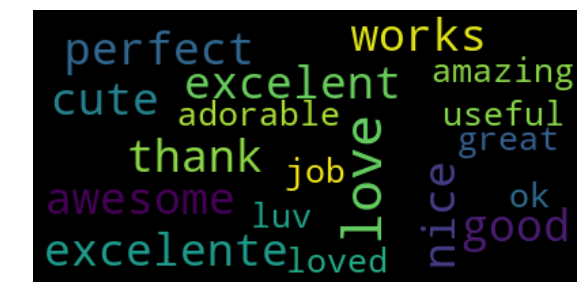

In [0]:
def get_top_tfidf_words(feature_names, sample, top_n=2):  
  """
  feature_names: an array of words. for example: ["love", "great", "product"]
  sample: sparse matrix
  top_n: (int) number of selected words
  
  """
  # sort indices pf sample, backward the sorted array and select top_n items
  sorted_nzs = np.argsort(sample.data)[:-(top_n+1):-1]
  # return an sub-array with sorted indices
  return feature_names[sample.indices[sorted_nzs]]

feature_names = np.array(tfidf.get_feature_names())

top_n_words = get_top_tfidf_words(feature_names, tfidf.transform(x_test), 30)

print("Top 15 words : {}".format(top_n_words))

get_wordcloud(' '.join(top_n_words))

In [0]:
lr = lrg_gridsearch.best_estimator_['clf']
lr

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
transformed_test = tfidf.transform(x_test)

predictions = lr.predict(transformed_test)

In [0]:
lr.decision_function(transformed_test)[:5,:]

array([[-0.78141299, -2.34323252,  0.23194212],
       [-3.73761513, -2.86715878,  2.81178863],
       [ 0.26363788, -1.85770313, -1.29498888],
       [-3.35516983, -2.69718682,  2.59642177],
       [-3.53049451, -2.80851512,  2.85467067]])

In [0]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       0.78      0.46      0.58      5296
           0       0.58      0.03      0.05      3330
           1       0.83      0.99      0.90     27851

    accuracy                           0.83     36477
   macro avg       0.73      0.49      0.51     36477
weighted avg       0.80      0.83      0.78     36477



In [0]:
prediction_prod = lr.predict_proba(transformed_test)
'''
# View the predicted probabilities of the first 10 observations
clf.predict_proba(test[features])[0:10]
'''

'\n# View the predicted probabilities of the first 10 observations\nclf.predict_proba(test[features])[0:10]\n'

In [0]:
prediction_prod[:5,:]

array([[0.32732186, 0.09131747, 0.58136068],
       [0.02279281, 0.05272717, 0.92448001],
       [0.61772102, 0.14742696, 0.23485201],
       [0.03282373, 0.06144989, 0.90572638],
       [0.02760442, 0.05516223, 0.91723335]])

In [0]:
predictions[:5]

array([ 1,  1, -1,  1,  1])

In [0]:
y_test[:5]

129061   -1
144551    1
168770   -1
4485      1
62596     1
Name: sentiment, dtype: int64

In [0]:
lr.classes_

array([-1,  0,  1])

**Train Score vs Test Score**

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$


In [0]:
from sklearn.metrics import accuracy_score
import numpy as np

dict_lr_score = {}

train_score = lrg_gridsearch.best_score_

dict_lr_score.update({'train_score' : [np.round(train_score, 2)]})

test_score = np.round(accuracy_score(y_test, predictions), 2)

dict_lr_score.update({'test_score' : [test_score]})



{'test_score': [0.83], 'train_score': [0.82]}

   train_score  test_score
0         0.82        0.83


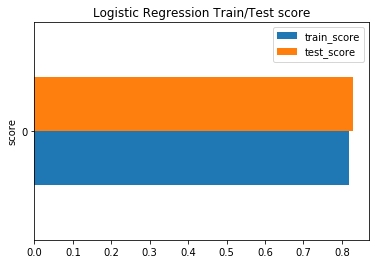

In [0]:
import matplotlib.pyplot as plt

df = pd.DataFrame(dict_lr_score)
df = df[['train_score', 'test_score']]
print(df)
df.plot(kind='barh')
plt.xlabel("")
plt.ylabel("score")
plt.title("Logistic Regression Train/Test score")
plt.show()